In [1]:
import numpy as np
import trimesh
from scipy.stats import special_ortho_group
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import open3d as o3d
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from keras.utils.vis_utils import plot_model
from random import sample
import random
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def create_vector(a,b,step):
    new_vec = []
    curr_val = a
    while curr_val < b:
        new_vec.append(curr_val)
        curr_val += step
        
    return new_vec

from ipywidgets import *

[Warning] Since Open3D 0.15, installing Open3D via conda is deprecated. Please re-install Open3D via: `pip install open3d -U`.


## Load Data 

In [2]:
m = 112
mesh = trimesh.load_mesh('surf1.ply')

In [3]:
V = np.array(mesh.vertices)
point_list = np.zeros(V.shape)

figures = np.zeros((m, len(point_list), 3))

for k in range(m):
    ply_mesh = trimesh.load_mesh('surf' + str(1 + k) + '.ply')
    figures[k, :, :] = np.array(ply_mesh.vertices)

In [4]:
r = np.random.randint(112)
M = np.zeros(figures[r,:,:].shape)

for k in range(m):
    if k != r: 
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], figures[r,:,:])
        M += V_transformed
    
M /= ( m - 1 )

for t in range(2):
    M_new = np.zeros(M.shape)
    total_d = []
    for k in range(m):
        T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
        total_d.append(d)
        M_new += V_transformed
    M = M_new
    M /= m
    
    if max(total_d) < 0.1:
        print("Converged!")
        break

In [5]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(M)
distances = pcd.compute_nearest_neighbor_distance()
max_dist = np.max(distances)

In [6]:
max_dist

0.4549764225447921

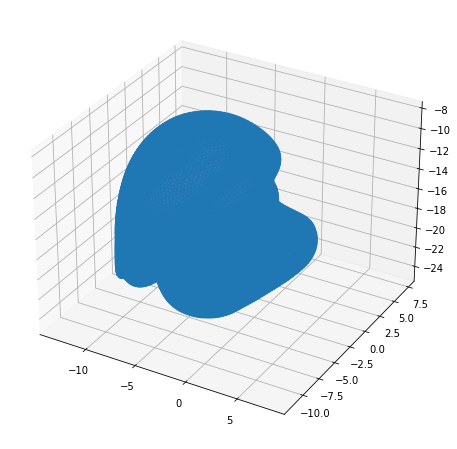

In [7]:
#%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
ax.scatter3D(M[:,0], M[:,1], M[:,2])
plt.show()

In [37]:
for k in range(m):
    T, V_transformed, d = trimesh.registration.procrustes(figures[k,:,:], M)
    figures[k,:,:] = V_transformed

In [38]:
original_figures = np.copy(figures)

## Extract Voxelized Data

In [39]:
X_min = np.min(np.min(figures[:,:,0])) - 1
Y_min = np.min(np.min(figures[:,:,1])) - 1
Z_min = np.min(np.min(figures[:,:,2])) - 1

figures[:,:,0] = figures[:,:,0] - X_min
figures[:,:,1] = figures[:,:,1] - Y_min
figures[:,:,2] = figures[:,:,2] - Z_min

X_max = np.max(np.max(figures[:,:,0])) + 1
Y_max = np.max(np.max(figures[:,:,1])) + 1
Z_max = np.max(np.max(figures[:,:,2])) + 1

In [40]:
voxel_shapes = np.load("voxelized_meshes.npy")

In [11]:
voxel1 = voxel_shapes[1,:,:,:]

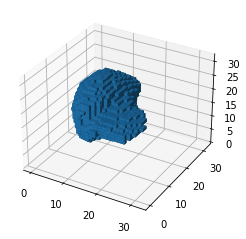

In [12]:
ax = plt.figure().add_subplot(projection='3d')
ax.voxels(voxel1)

plt.show()

## Occupancy Probability IM Net Architecture

In [13]:
encoding_dim = 128

In [14]:
latent_dimension = keras.Input(shape = (128,))
input_point = keras.Input(shape = (3))

complete_input = layers.Concatenate(axis=1)([latent_dimension, input_point])

x = layers.Dense(128 * 16)(complete_input)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 8)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 4)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128 * 2)(x)
x = layers.LeakyReLU()(x)
x = layers.Concatenate(axis=1)([x, complete_input])
x = layers.Dense(128)(x)
x = layers.LeakyReLU()(x)
x = layers.Dense(1)(x)
probability_function = activations.sigmoid(x)

im_net = keras.Model(inputs=[latent_dimension, input_point], outputs=probability_function)
im_net.compile(optimizer='adam', loss="binary_crossentropy", metrics=[tf.keras.metrics.MeanSquaredError()])

2023-08-09 12:24:18.482528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
im_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 131)          0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 2048)         270336      ['concatenate[0][0]']        

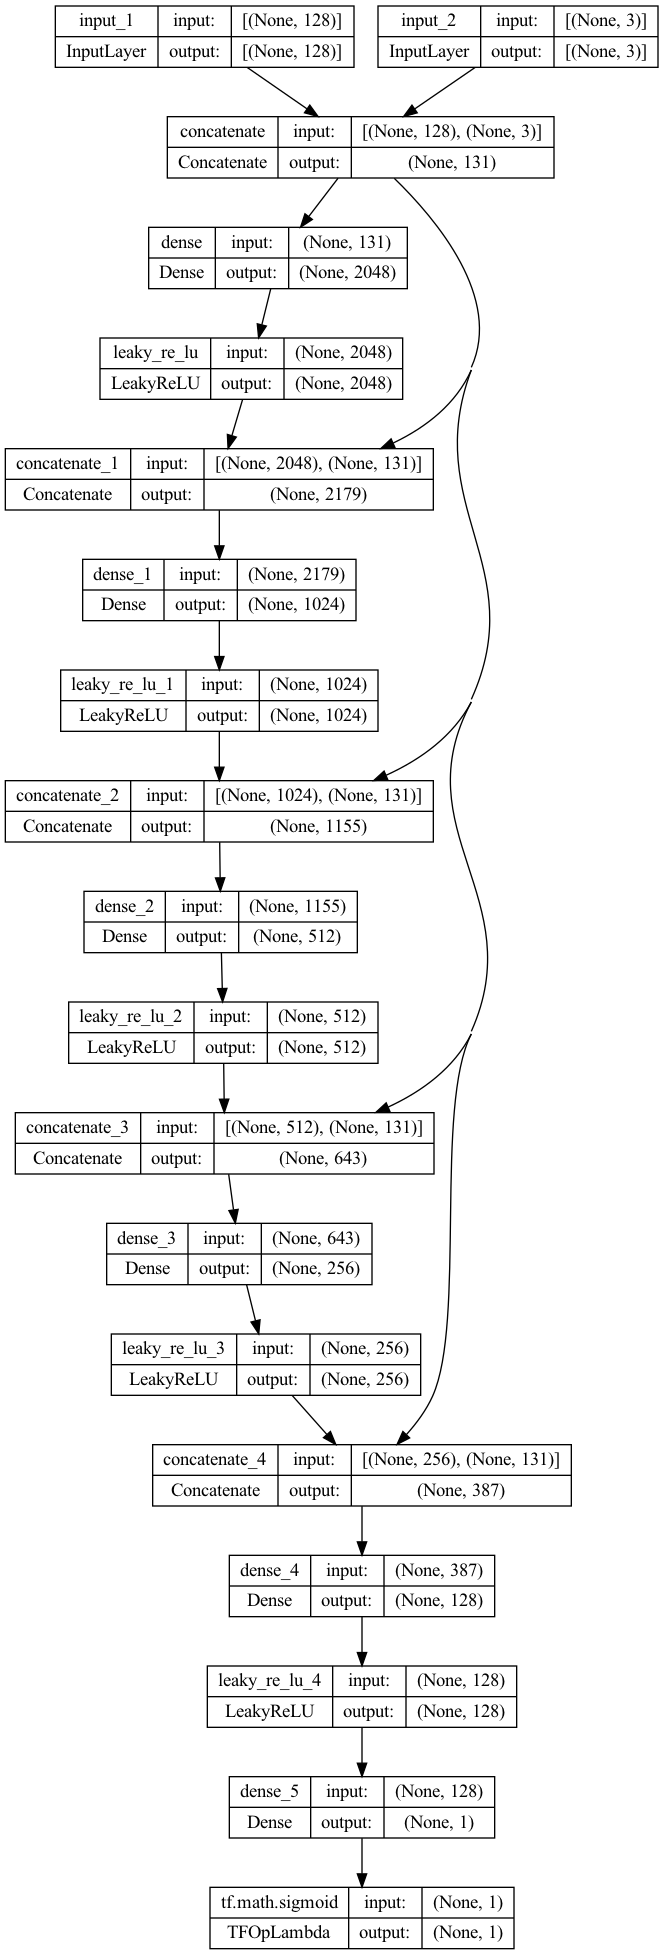

In [16]:
plot_model(im_net, to_file='im_net_architecture.png', show_shapes=True, show_layer_names=True)

## Load Latent Space Encoder Model

In [17]:
input_imag = keras.Input(shape = (32,32,32,1))

x = layers.Conv3D(16, (5,5,5))(input_imag)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)
x = layers.Conv3D(1, (5,5,5))(x)
x = layers.Flatten()(x)
x = layers.Dense(128)(x)
encoded = layers.UnitNormalization()(x)

In [18]:
encoder = keras.Model(input_imag, encoded)
encoder = load_model("best_encoder_with_normalization_32.h5")

WARNING - 2023-08-09 12:24:18,933 - hdf5_format - No training configuration found in the save file, so the model was *not* compiled. Compile it manually.


In [23]:
latent_input = keras.Input(shape = (128,))

x = layers.Dense(1728)(latent_input)
x = layers.Reshape((12,12,12,1))(x)
x = layers.Conv3D(2, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(4, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(8, (5,5,5))(x)
x = layers.LeakyReLU()(x)
x = layers.UpSampling3D((2,2,2))(x)
x = layers.Conv3D(1, (9,9,9))(x)
decoded = activations.sigmoid(x)

In [24]:
decoder = keras.Model(latent_input, decoded)
decoder = load_model('best_decoder_with_normalization_32')

WARNING - 2023-08-09 12:24:58,156 - load - No training configuration found in save file, so the model was *not* compiled. Compile it manually.


## Train / Test Split

In [25]:
random.seed(10)
test_indices = random.sample(range(m),23)
train_indices = list(filter(lambda x : x not in test_indices, range(m)))
val_indices = random.sample(train_indices,11)
train_indices = list(filter(lambda x : x not in val_indices, train_indices))

In [26]:
latent_representation = encoder.predict(voxel_shapes)

4/4 [==============================] - 1s 194ms/step


In [27]:
decoded_representation = decoder.predict(latent_representation)

4/4 [==============================] - 2s 459ms/step


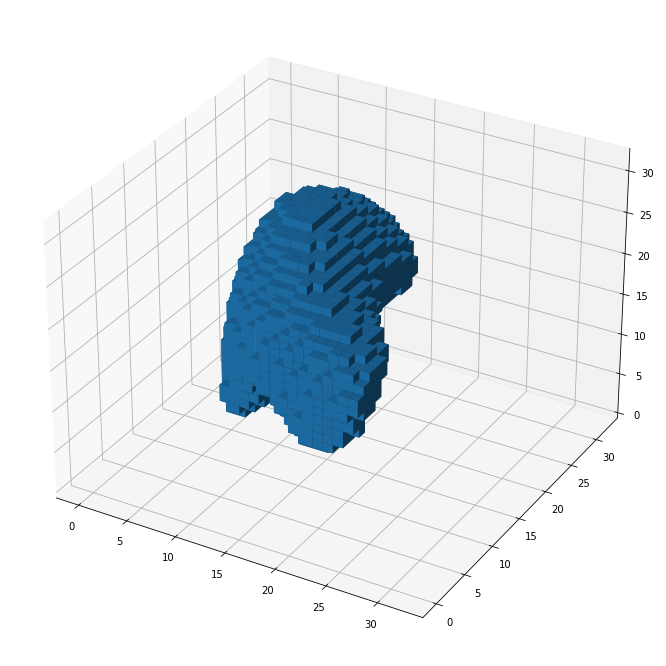

In [28]:
index = 60
voxel1 = decoded_representation[index,:,:,:,0]
mu = np.mean(voxel1.flatten())
sigma = np.std(voxel1.flatten())
carved_voxel = np.zeros(voxel1.shape)

for i in range(32):
    for j in range(32):
        for k in range(32):
            if voxel1[i,j,k] > mu + sigma:
                carved_voxel[i,j,k] = 1
                
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
ax.voxels(carved_voxel)

plt.show()

## Model Training

In [29]:
mean = [0,0,0]
cov = 2 * max_dist * np.array([[1,0,0], [0,1,0],[0,0,1]])

In [30]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
mc = ModelCheckpoint('best_im_model_32.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [31]:
start = time.time()

for k in range(1):
    
    print("Generating Training Set:", k)
    
    points = np.zeros((0,3))
    latent_dimensions = np.zeros((0,128))
    output = np.ones((0,))
    
    for model in train_indices: 

        ply_mesh = trimesh.load_mesh('surf' + str(1 + model) + '.ply')
        check_in_or_out = trimesh.proximity.ProximityQuery(ply_mesh)
        V = np.copy(original_figures[model, :, :])
        V += np.random.multivariate_normal(mean, cov,V.shape[0])
        truth_values = 0.5 * (np.sign(check_in_or_out.signed_distance(V)) + 1)
                
        points = np.concatenate((points, V))
        output = np.concatenate((output, truth_values))
        latent_dimensions = np.concatenate( (latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(truth_values)).T ) )
        
    print("Generating Validation Set:", k)

    val_points = np.zeros((0,3))
    val_latent_dimensions = np.zeros((0,128))
    val_output = np.ones((0,))
    
    for model in val_indices: 

        ply_mesh = trimesh.load_mesh('surf' + str(1 + model) + '.ply')
        check_in_or_out = trimesh.proximity.ProximityQuery(ply_mesh)
        V = np.copy(original_figures[model, :, :])
        V += np.random.multivariate_normal(mean, cov,V.shape[0])
        truth_values = 0.5 * (np.sign(check_in_or_out.signed_distance(V)) + 1)
        
        val_points = np.concatenate((val_points, V))
        val_output = np.concatenate((val_output, truth_values))
        val_latent_dimensions = np.concatenate( (val_latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(truth_values)).T ) )
               
    print("Training Autoencoder")
    im_net.fit([latent_dimensions, points], output, epochs=10, batch_size=1024, shuffle=True, validation_data=([val_latent_dimensions, val_points], val_output), callbacks=[es,mc])

end = time.time()
print(end - start)

Generating Training Set: 0
Generating Validation Set: 0
Training Autoencoder
Epoch 1/10
988/989 [============================>.] - ETA: 0s - loss: 0.4295 - mean_squared_error: 0.1407
Epoch 1: val_loss improved from inf to 0.53103, saving model to best_im_model_32.h5
989/989 [==============================] - 79s 80ms/step - loss: 0.4295 - mean_squared_error: 0.1407 - val_loss: 0.5310 - val_mean_squared_error: 0.1514
Epoch 2/10
988/989 [============================>.] - ETA: 0s - loss: 0.2691 - mean_squared_error: 0.0852
Epoch 2: val_loss did not improve from 0.53103
989/989 [==============================] - 80s 81ms/step - loss: 0.2691 - mean_squared_error: 0.0852 - val_loss: 0.5927 - val_mean_squared_error: 0.1586
Epoch 3/10
988/989 [============================>.] - ETA: 0s - loss: 0.2336 - mean_squared_error: 0.0736
Epoch 3: val_loss did not improve from 0.53103
989/989 [==============================] - 82s 83ms/step - loss: 0.2336 - mean_squared_error: 0.0736 - val_loss: 0.5761 -

## Model Testing

In [32]:
test_points = np.zeros((0,3))
test_latent_dimensions = np.zeros((0,128))
test_output = np.ones((0,))
    
for model in test_indices: 

    ply_mesh = trimesh.load_mesh('surf' + str(1 + model) + '.ply')
    check_in_or_out = trimesh.proximity.ProximityQuery(ply_mesh)
    V = np.copy(original_figures[model, :, :])
    V += np.random.multivariate_normal(mean, cov,V.shape[0])
    truth_values = 0.5 * (np.sign(check_in_or_out.signed_distance(V)) + 1)
        
    test_points = np.concatenate((test_points, V))
    test_output = np.concatenate((test_output, truth_values))
    test_latent_dimensions = np.concatenate( (test_latent_dimensions, np.tile(np.expand_dims(latent_representation[model,:], axis = 0).T, len(truth_values)).T ) )
                     

In [33]:
im_net = load_model("best_im_model_32.h5")

In [34]:
im_net.evaluate([test_latent_dimensions, test_points], test_output, verbose = True) 

9326/9326 [==============================] - 17s 2ms/step - loss: 0.8669 - mean_squared_error: 0.1933


[0.8669255971908569, 0.19329358637332916]

In [35]:
test_predictions = im_net.predict([test_latent_dimensions, test_points])

9326/9326 [==============================] - 16s 2ms/step


## Latent Space Traversal -> Shape Space

In [110]:
bound_x = [X_min, X_max + X_min]
bound_y = [Y_min, Y_max + Y_min]
bound_z = [Z_min, Z_max + Z_min]

In [111]:
X = create_vector(bound_x[0], bound_x[1], 0.5)
Y = create_vector(bound_y[0], bound_y[1], 0.5)
Z = create_vector(bound_z[0], bound_z[1], 0.5)

In [112]:
latent_dimension = latent_representation[5,:]
mesh = trimesh.load_mesh('surf6.ply')

In [113]:
latent_dimension = latent_dimension.reshape((1,128))

In [114]:
W = np.meshgrid(X, Y, Z, indexing='ij')[0]

In [115]:
latent_dims = []
points = []

for i, x in enumerate(X): 
    for j, y in enumerate(Y): 
        for k, z in enumerate(Z): 
            points.append(np.array([x,y,z]))
            latent_dims.append(latent_dimension)

latent_dims = np.array(latent_dims)
points = np.array(points)

In [116]:
latent_dims = latent_dims.reshape((len(latent_dims), 128))

In [118]:
predictions = im_net.predict([latent_dims, points])

4836/4836 [==============================] - 9s 2ms/step


In [123]:
less_points = []

for k, pred in enumerate(predictions): 
    if pred >= np.mean(predictions): 
        less_points.append([points[k,0], points[k,1], points[k,2]])
            
less_points = np.array(less_points)

<IPython.core.display.Javascript object>


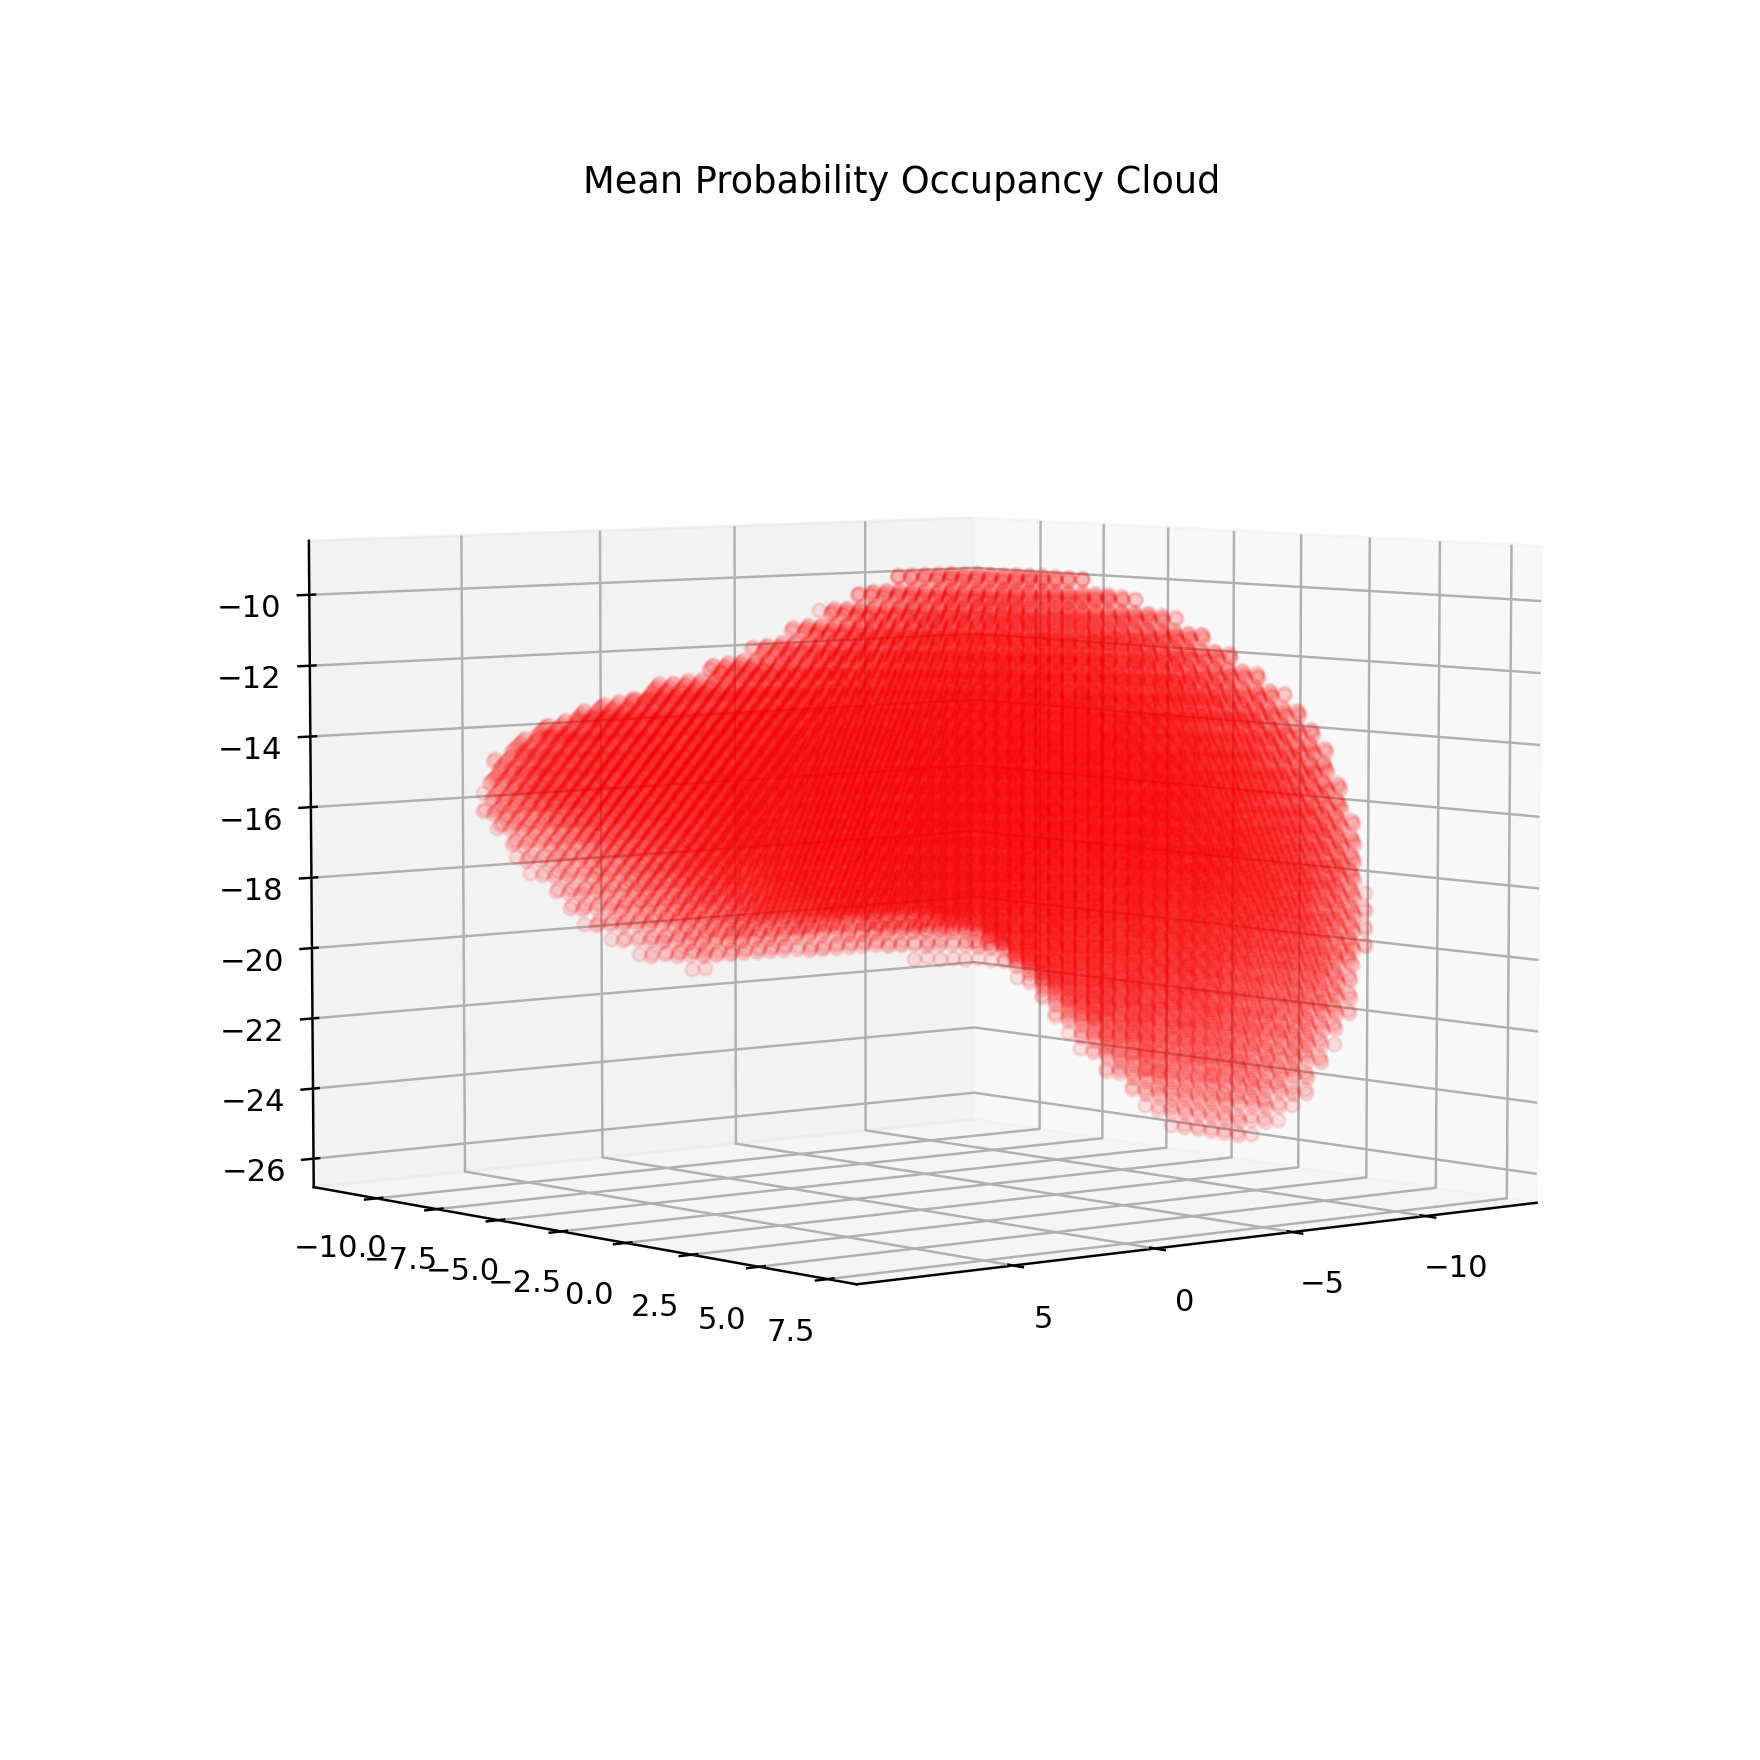

In [127]:
%matplotlib notebook

# Creating figure
fig = plt.figure(figsize = (8, 8))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(less_points[:,0], less_points[:,1], less_points[:,2], c="r", depthshade=False, alpha = 0.1)
#ax.scatter3D(mesh.vertices[:,0], mesh.vertices[:,1], mesh.vertices[:,2])
plt.title("Mean Probability Occupancy Cloud")

# show plot
plt.show()